In [ ]:
cd "/content/drive/MyDrive/AA Hulse Kemp Lab/Random/FruitQuality"

/content/drive/MyDrive/Work/Hulse Kemp Lab/Random/FruitQuality


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.1 MB/s eta 0:00:00


In [ ]:
import os

import cv2
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = './Images/'
MASK_DIR = './Masks/'

In [ ]:
CLASSES = ['seed', 'pulp', 'albedo', 'flavedo']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# ds = tf.data.Dataset(os.listdir(DATA_DIR))
ds = tf.data.Dataset.from_tensor_slices(os.listdir(MASK_DIR))

In [ ]:
def process_mask_ids(mask_path):
  return tf.strings.regex_replace(mask_path,".png", "")

ds = ds.map(process_mask_ids, num_parallel_calls=AUTOTUNE)

In [ ]:
for f in ds.take(5):
  print(f)

tf.Tensor(b'FTP.6.60.71_Fruit Quality Fruit1_1_2021-11-17-11-09-34.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.61.44_Fruit Quality Fruit2_1_2021-11-24-09-29-42.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.60.27_Fruit Quality Fruit3_1_2021-11-09-11-44-49.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.60.78_Fruit Quality Fruit5_1_2021-11-17-01-03-54.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.60.66_Fruit Quality Fruit3_1_2021-11-17-10-46-01.jpg', shape=(), dtype=string)


In [ ]:
def decode_img(img, channels=3):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=channels)

  return tf.image.pad_to_bounding_box(img,0,0, 1024, 1024)

def process_path(file_path):
  # Load the raw data from the file as a string
  img_path = tf.io.read_file(tf.strings.join([DATA_DIR, os.path.sep,file_path]))
  img = decode_img(img_path)

  mask_path = tf.io.read_file(tf.strings.join([MASK_DIR, os.path.sep,file_path, '.png']))
  mask = decode_img(mask_path, channels=1)
  return img, mask

img_ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

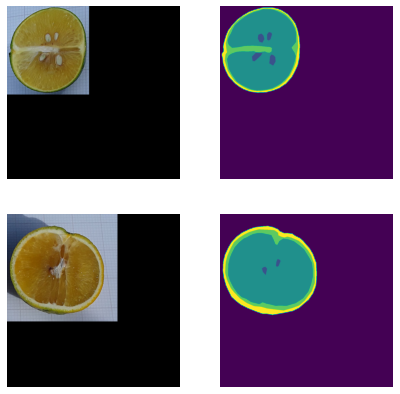

In [ ]:
plt.figure(figsize=(7, 7))
n = 2
for c,(img_, mask_) in enumerate(img_ds.take(n)):
  plt.subplot(n, 2, 2*c+1)
  plt.axis("off")
  plt.imshow(img_.numpy().astype("int32"))
  plt.subplot(n, 2, 2*c+2)
  plt.imshow(mask_.numpy()[:,:,0].astype("int32"))
  plt.axis("off")

In [ ]:
SIZE = len(img_ds)
SIZE

23

In [ ]:
TRAIN_SIZE = int(0.6 * SIZE)
VAL_SIZE = int(0.2 * SIZE)
LR=0.001

In [ ]:
train_ds = img_ds.take(TRAIN_SIZE)
val_ds = img_ds.skip(TRAIN_SIZE).take(VAL_SIZE)
test_ds = img_ds.skip(TRAIN_SIZE + VAL_SIZE)

In [ ]:
len(train_ds)

13

In [ ]:
len(val_ds)

4

In [ ]:
len(test_ds)

6

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Input((1024,1024,3)),
  tf.keras.layers.Conv2D(512, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same')
])

In [ ]:
optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
model.build((None, 1024,1024,3))

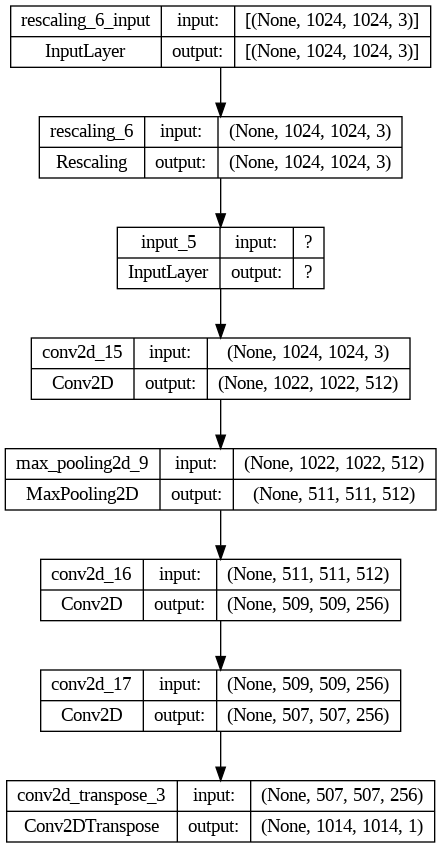

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit(
    train_ds, 
    steps_per_epoch=len(train_ds), 
    epochs=5, 
    callbacks=callbacks, 
    validation_data=val_ds, 
    validation_steps=len(val_ds),
)

Epoch 1/5


ValueError: ignored